In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plot
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
)
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
dir = Path.cwd()
laliga_path = dir.parent / "laliga.sqlite"
if laliga_path.exists() == False:
        raise FileNotFoundError(
            f"Not found 'laliga.sqlite' neither in {laliga_path} nor in {parent_path}"
        )
    
try:
     conn = sqlite3.connect(laliga_path)
except sqlite3.OperationalError as e:
    print(f"Could not connect to data base 'laliga.sqlite'.")

In [3]:
df = pd.read_sql("SELECT * FROM Matches;", conn)

We clean the data det by removing NaN scores and define *home_goals* and *away_goals*.

In [4]:
matches = df.copy()
valid_matches = matches[matches['score'].notna() & matches['score'].str.contains(':')].copy()
valid_matches[['home_goals', 'away_goals']] = (valid_matches['score'].str.split(':', expand=True).astype(int))

In [5]:
def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return '1'
    elif row['home_goals'] < row['away_goals']:
        return '2'
    else:
        return 'X' 

In [6]:
valid_matches['result'] = valid_matches.apply(get_result, axis=1)

In [7]:
def generate_date(row):
    date = row['date'].split("/")
    month = date[0]
    day = date[1]
    year = date[2]
    season = row['season'].split("-")[0]
    year = season[0:2] + year
    return f"{month}/{day}/{year}"

In [8]:
valid_matches["date"] = valid_matches.apply(generate_date, axis=1)
valid_matches[["month", "day", "year"]] = valid_matches["date"].str.split("/", expand=True).astype(int)
valid_matches = valid_matches.drop(columns=["season", "date", "score", "time", "home_goals", "away_goals"])

In [9]:
teams = pd.unique(valid_matches[["home_team", "away_team"]].values.ravel())

In [10]:
encoder = OneHotEncoder(handle_unknown="ignore", categories=[teams, teams])
encoded = encoder.fit_transform(valid_matches[["home_team", "away_team"]])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(["home_team", "away_team"]))

In [11]:
valid_matches = valid_matches.drop(columns=["home_team", "away_team"])

In [12]:
df_train = pd.concat([
    encoded_df.reset_index(drop=True),
    valid_matches.reset_index(drop=True)
], axis=1)

df_train = df_train.loc[df_train["year"] < 2021]

In [13]:
y_train = df_train["result"]
X_train = df_train.drop("result", axis=1)

In [14]:
random_forest = RandomForestClassifier(random_state=42)

In [15]:
random_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
df_test = pd.concat([
    encoded_df.reset_index(drop=True),
    valid_matches.reset_index(drop=True)
], axis=1)
df_test = df_test.loc[df_test["year"] >= 2021]

In [17]:
y_test = df_test["result"]
X_test = df_test.drop("result", axis=1)

In [18]:
y_pred = random_forest.predict(X_test)

We have selected a ```RandomForestClassifier``` model to fit the data because other models do not predict ties or predict them very rarely. This model yields more variate results and still presents results with a 45% of accuracy.

Accuracy on test Gradient Boosting Classifier: 0.4500


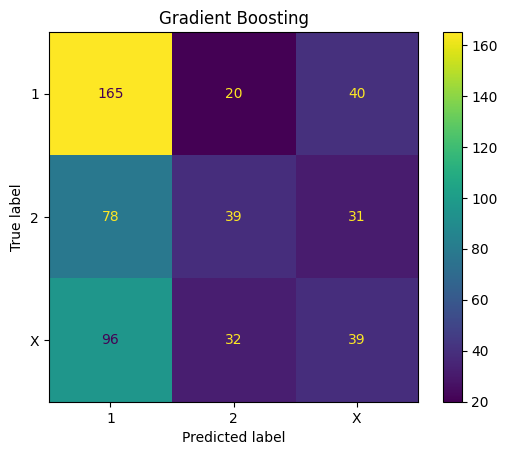

In [19]:
feature_names = sorted(y_test.unique())
conf_mat_liblinear = confusion_matrix(y_test, y_pred, labels=feature_names)
disp_liblinear = ConfusionMatrixDisplay(confusion_matrix=conf_mat_liblinear, display_labels=feature_names)
disp_liblinear.plot()
plot.title("Gradient Boosting")
plot.savefig("confusion_matrix.png", dpi=300)

print(f"Accuracy on test Gradient Boosting Classifier: {accuracy_score(y_test, y_pred):.4f}")